Implement K-means. Your implementation should perform multiple random
initializations and keep the best result. Make sure that your code does not crash when one of your initializations results in an empty cluster.

For each dataset, plot the sum of squared errors (SSE), the CH index, the SC, and the NMI for the best restart (based on SSE) as a function of the number of clusters K = 2, 3, 4, 5. For each K value, again include a scatter plot, in which different symbols are used to signify each label, and different colors represent the learned cluster assignments.

References: <br>
https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/ <br>
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html <br>
http://fromdatawithlove.thegovans.us/2013/05/clustering-using-scikit-learn.html <br>

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import random

In [2]:
dataSets = ['datasets/dataset1.txt', 'datasets/dataset2.txt', 'datasets/dataset3.txt']
clusters = [2, 3, 4, 5]

In [3]:
# perfoms a single iteration of K-Means

def assignClusters(feature_matrix, centers):
    clusters  = {}
    labels = []
    for p in feature_matrix:        
        closestCenter = min([(c[0], np.linalg.norm(p - centers[c[0]])) for c in enumerate(centers)], key=lambda t:t[1])[0]
        labels.append(closestCenter)
        
        if clusters.get(closestCenter) is None:
            clusters[closestCenter] = [p]
        else:
            clusters[closestCenter].append(p)            
    return (clusters, labels)
 
def refineCenters(clusters):
    newCenters = []
    centers = sorted(clusters.keys())
    for c in centers:
        newCenters.append(np.mean(clusters[c], axis = 0))
    return newCenters
 
def isEqual(oldCenters, newCenters):
    return (set([tuple(c) for c in oldCenters]) == set([tuple(c) for c in newCenters]))

def KMeansIteration(feature_matrix, K, initCenters=[]):
    
    oldCenters = random.sample(list(feature_matrix), K)
    newCenters = random.sample(list(feature_matrix), K) if not initCenters else initCenters
    labels = []
    while not isEqual(oldCenters, newCenters):
        oldCenters = newCenters
        clusters, labels = assignClusters(feature_matrix, oldCenters)
        newCenters = refineCenters(clusters)
    return (newCenters, labels)

In [4]:
# returns feature_matrix(points) and true clusters for those points

def formatDataset(inputDataSet):    
    dataset = np.loadtxt(inputDataSet)
    feature_matrix = dataset[:, :-1]
    trueClusters = dataset[:,2]
    return feature_matrix, trueClusters

In [5]:
# plots line graph of different evaluation metrics

metricLabels = ['SSE', 'NMI', 'SC', 'CH']

def evaluateClusters(clusters, evaluationMetrics):  
    plt.figure(1)
    plt.figure(1).set_size_inches(18, 10)
    i = 221
    for metric in evaluationMetrics:        
        plt.subplot(i)        
        plt.plot(clusters, metric)
        plt.title(metricLabels[i-221])
        i=i+1
    plt.show()

In [6]:
# perform 50 random initializations and return the best result based on minimum SSE.

def findBestClustering(feature_matrix, trueClusters, K):
    bestCenters = []
    bestLabels = []
    for i in range(1, 50):    
        minSSE = 1000000
        centers, kmeansLabels = KMeansIteration(feature_matrix, K)
        sse = metrics.mean_squared_error(trueClusters, kmeansLabels)
        if sse < minSSE:
            minSSE = sse
            bestCenters = centers
            bestLabels = kmeansLabels
    return bestCenters, bestLabels 

In [7]:
# plots different clusters in different colors

def plotClusters(plotID, K, feature_matrix, kmeansCenters, kmeansLabels, trueLabels):
    
    feature1 = feature_matrix[:, 0]
    feature2 = feature_matrix[:, 1]
    
    colors = ['blue', 'gold', 'green', 'red', 'cyan', 'magenta', 'dimgreay', 'saddlebrown', 'purple']
    clusterColours = [colors[kl] for kl in kmeansLabels]
    
    shapes = ['.', 'o', 'D', '^', 'x']
    clusterShapes = [shapes[int(tl)] for tl in trueLabels]
    
    plt.subplot(plotID)
    
    for i in range(len(feature_matrix)):
        plt.scatter(feature1[i], feature2[i], marker=clusterShapes[i], s=40, lw=0, alpha=0.7, color=clusterColours[i])        
    
    plt.scatter(kmeansCenters[:, 0], kmeansCenters[:, 1], marker='o', c="black", alpha=1, s=200)    

    for index, center in enumerate(kmeansCenters):
        plt.scatter(center[0], center[1], marker='$%d$' % index, alpha=1, s=50, color='white')

    pltTitle = "K = $%d$"%K
    plt.title(pltTitle)
    plt.xlabel("X")
    plt.ylabel("Y")

In [8]:
# apply K-Means to given dataset

def applyKMeans(feature_matrix, trueClusters, clusters, initCenters=[]):  
    
    evaluationMetrics = []
    
    SSE = []
    CH = []
    SC = []
    NMI = []
    
    plt.figure(1)
    plt.figure(1).set_size_inches(18, 10)
    i = 221
    
    for K in clusters:        
        kmeansCenters, kmeansLabels = findBestClustering(feature_matrix, trueClusters, K) if not initCenters else KMeansIteration(feature_matrix, K, initCenters)
        
        kmeansCenters = np.asarray(kmeansCenters)
        kmeansLabels = np.asarray(kmeansLabels)
        
        plotClusters(i, K, feature_matrix, kmeansCenters, kmeansLabels, trueClusters)
        i=i+1
        
        SSE.append(metrics.mean_squared_error(trueClusters, kmeansLabels))
        NMI.append(metrics.normalized_mutual_info_score(trueClusters, kmeansLabels))
        SC.append(metrics.silhouette_score(feature_matrix, kmeansLabels, metric='euclidean'))
        CH.append(metrics.calinski_harabaz_score(feature_matrix, kmeansLabels))
    
    plt.show()
    
    evaluationMetrics.append(SSE)
    evaluationMetrics.append(NMI)
    evaluationMetrics.append(SC)
    evaluationMetrics.append(CH)
    
    return evaluationMetrics

In [9]:
def runKMeans(dataSet):
    feature_matrix, trueClusters = formatDataset(dataSet)
    evaluationMetrics = applyKMeans(feature_matrix, trueClusters, clusters)
    evaluateClusters(clusters, evaluationMetrics)

# Analysis of DataSet-1

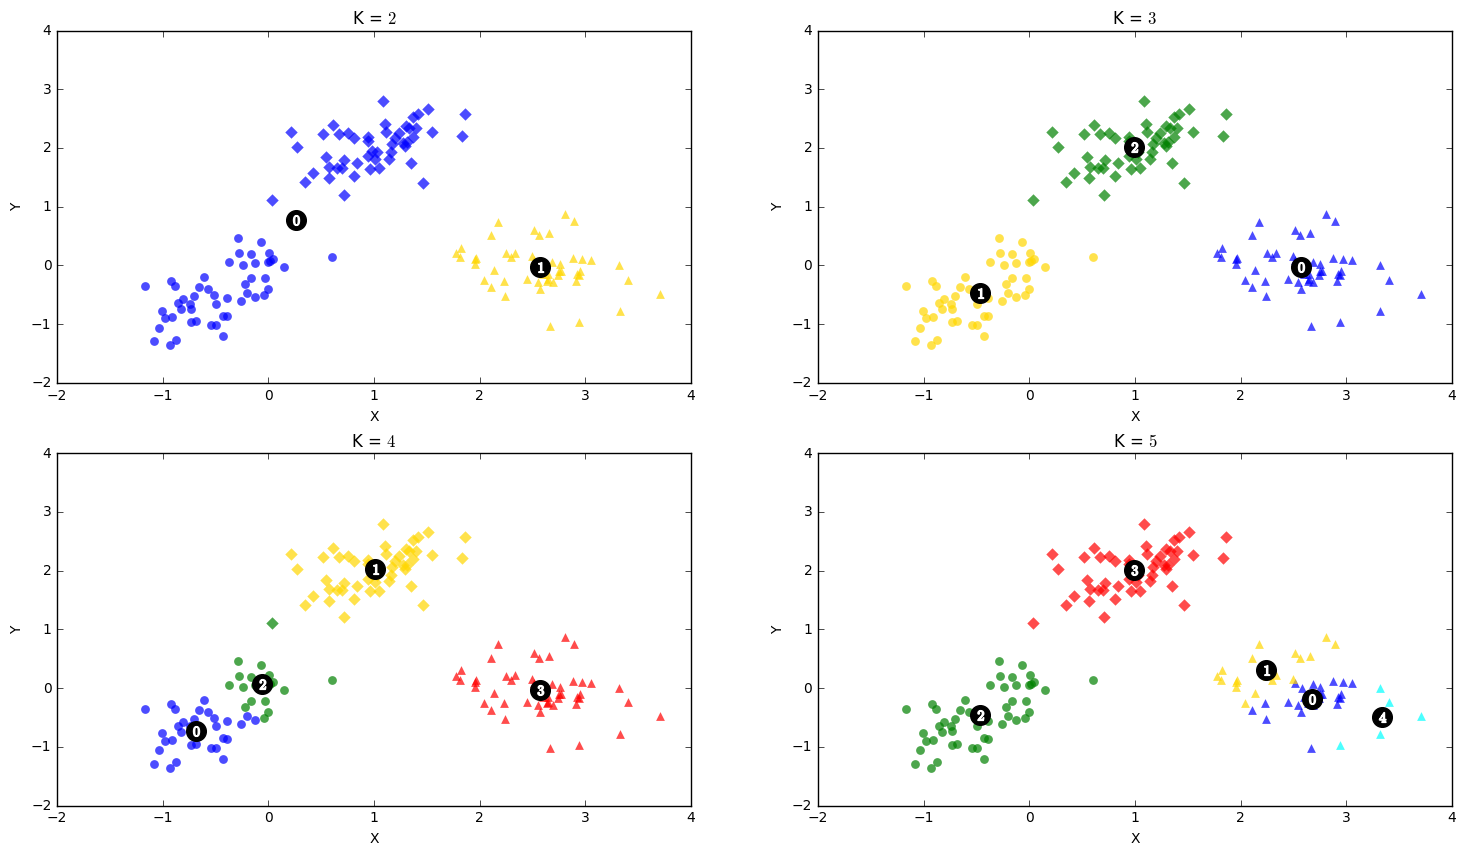

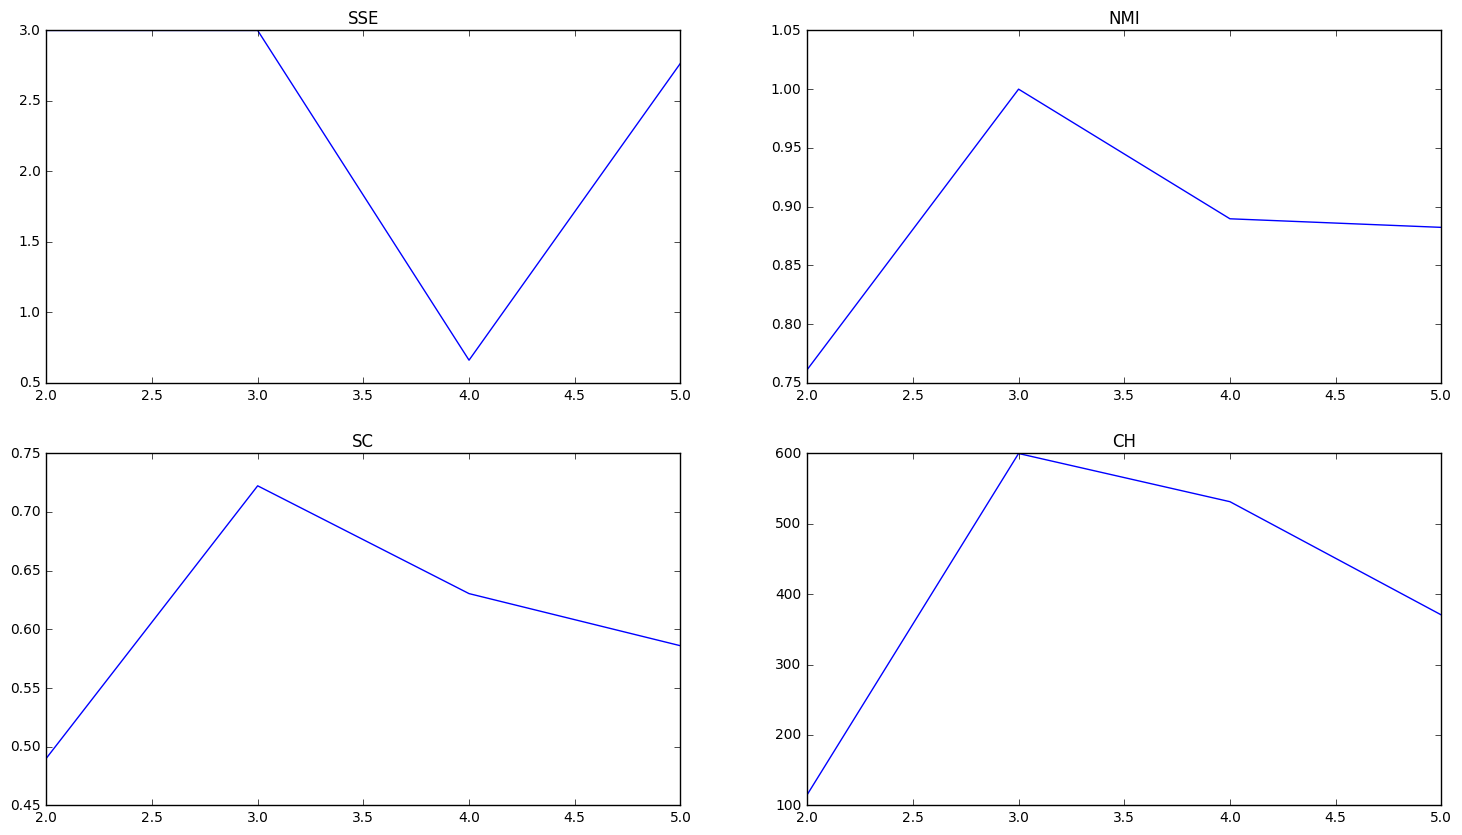

In [10]:
runKMeans(dataSets[0])

# Analysis of DataSet-2

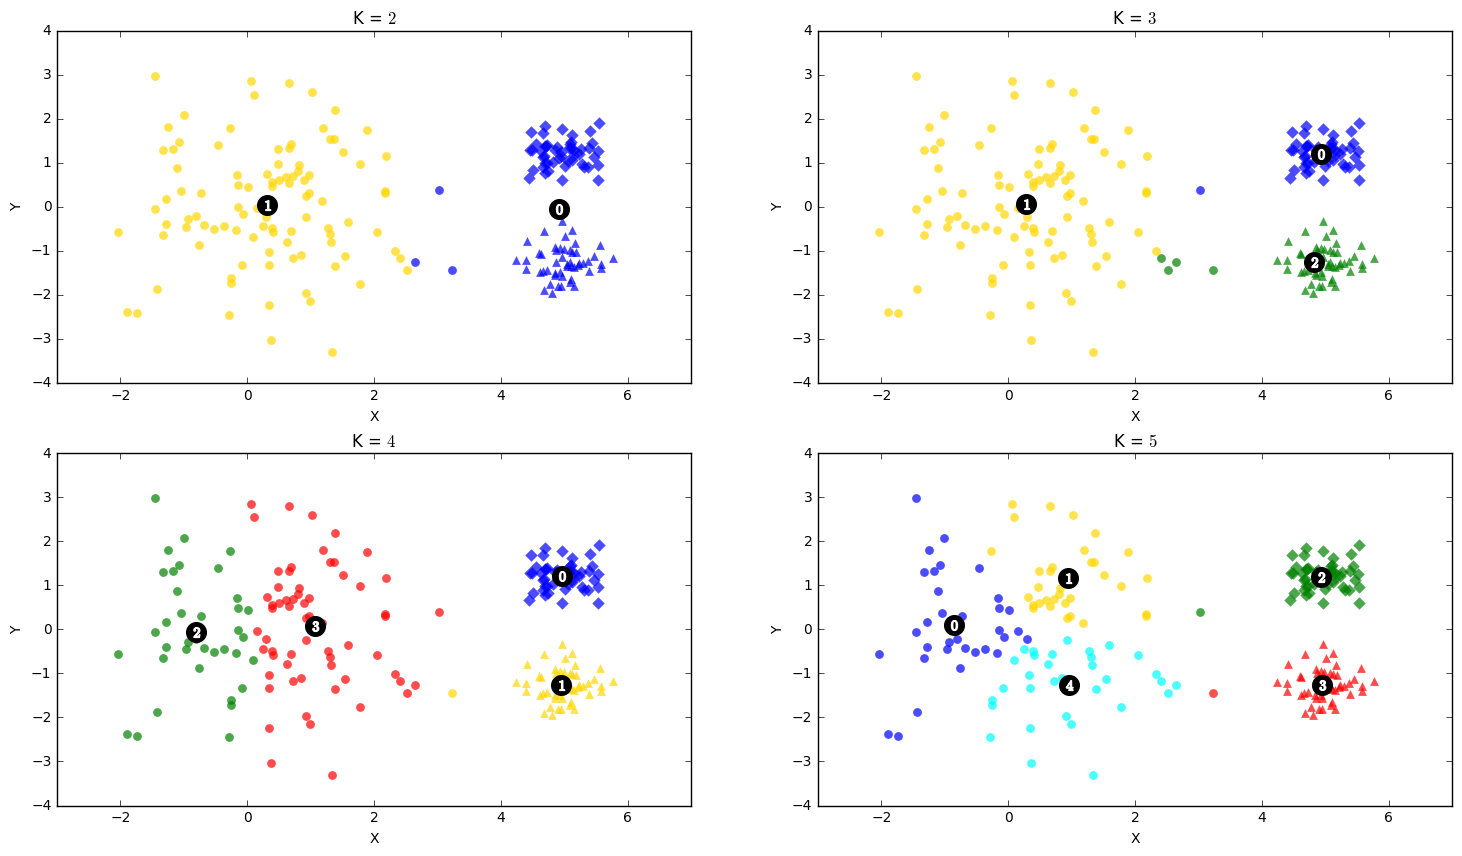

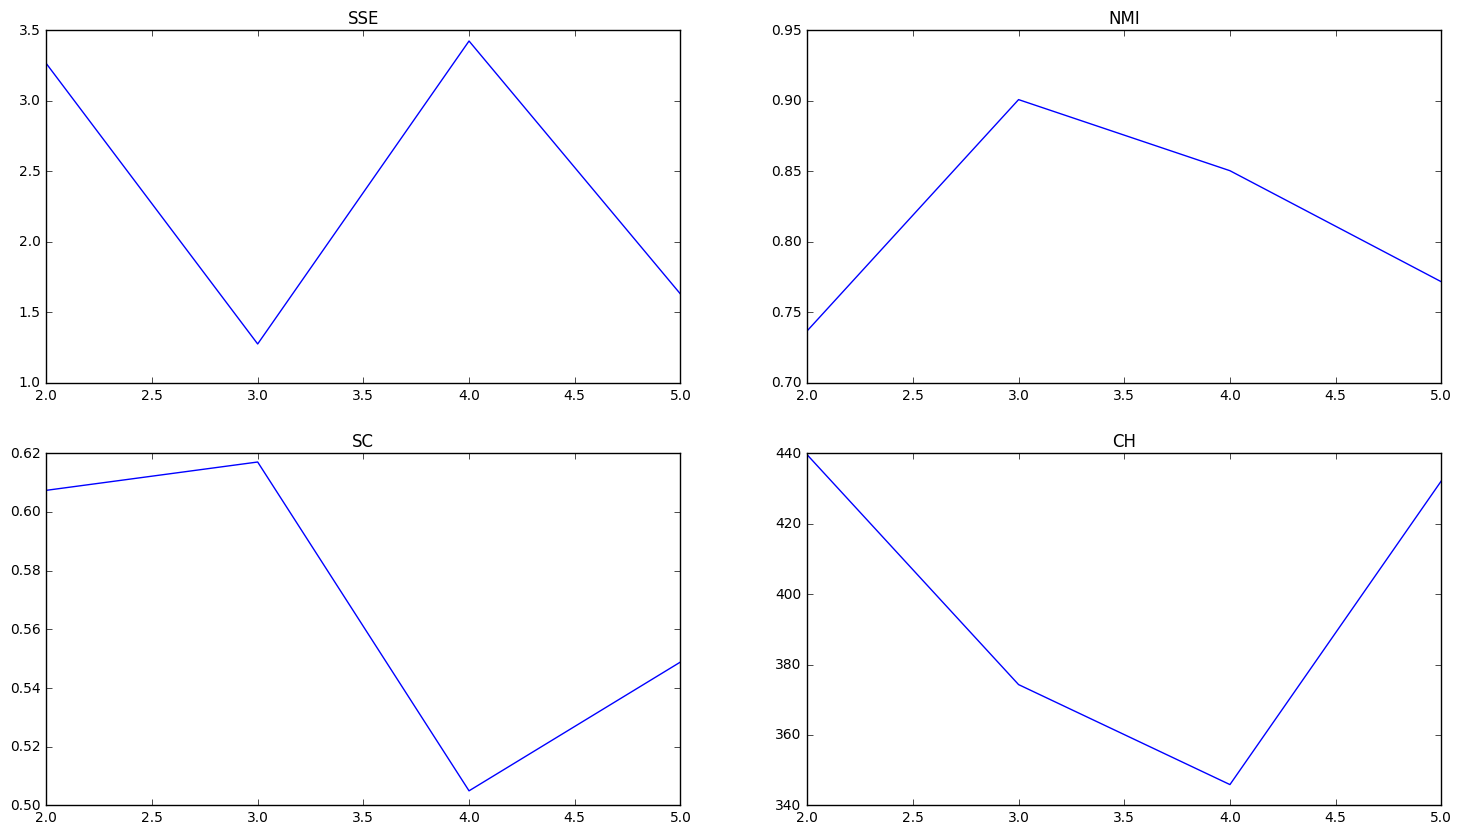

In [11]:
runKMeans(dataSets[1])

# Analysis of DataSet-3

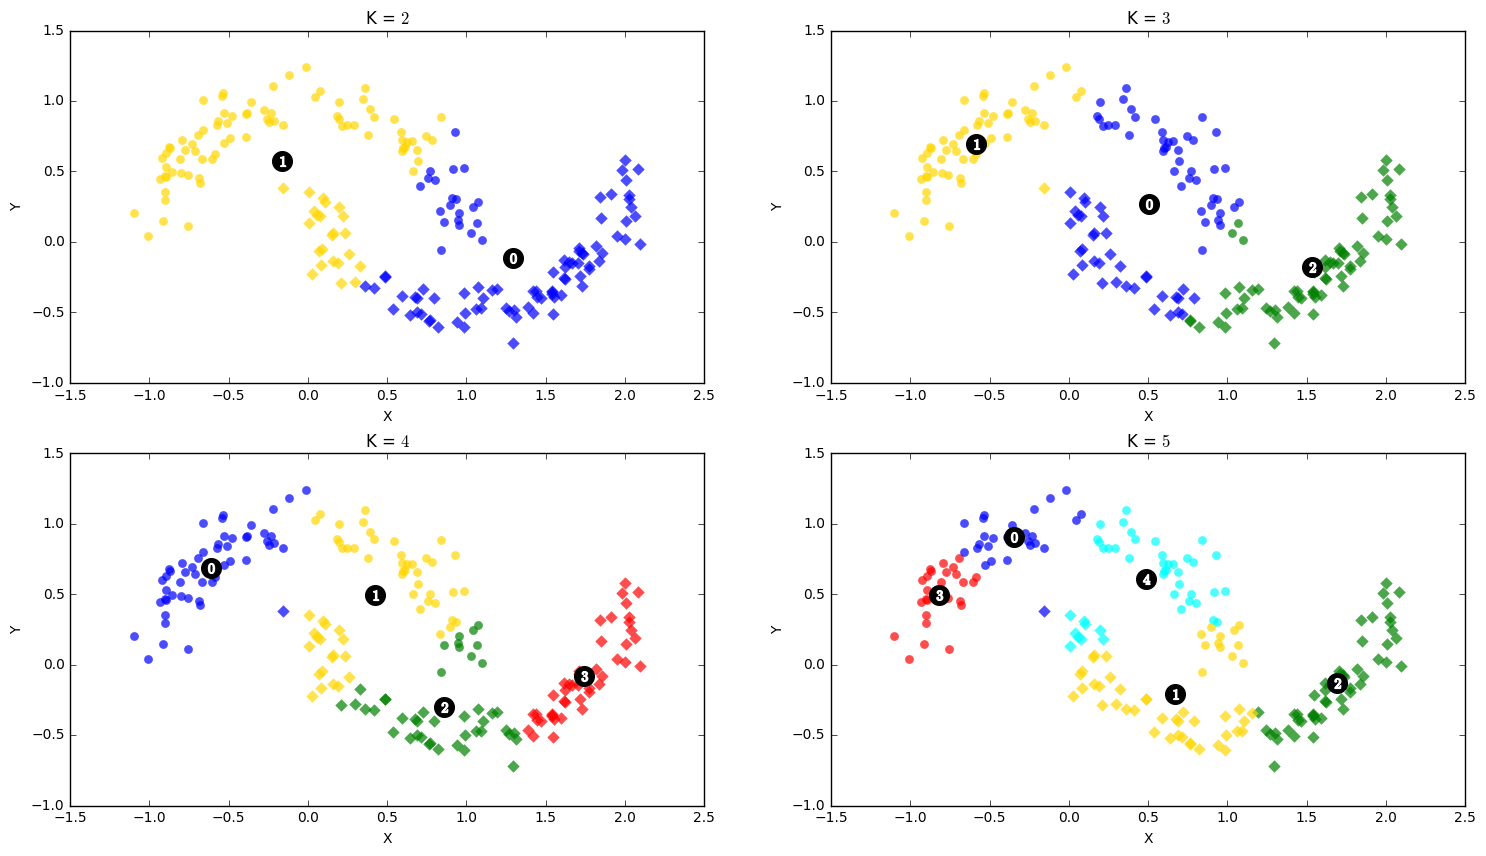

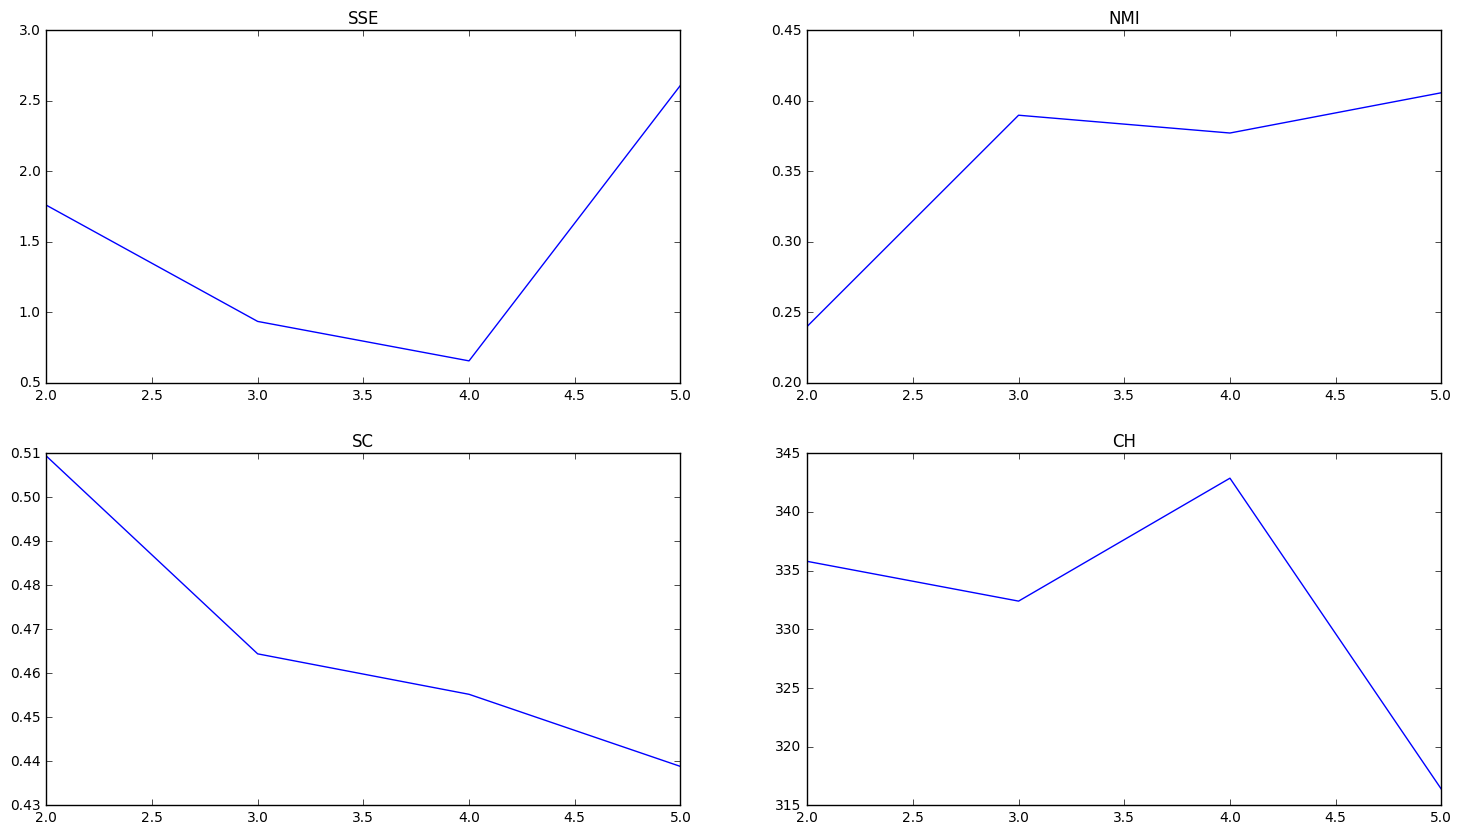

In [12]:
runKMeans(dataSets[2])

In [13]:
def printMetrics(evaluationMetrics):
    metricLabels = ['SSE', 'NMI', 'SC', 'CH']
    for e, m in zip(evaluationMetrics, metricLabels):
        print(m, "=", e[0])

# Use this function for custom initial centers 

In [14]:
def runKMeansCustom(dataSet, initCenters):
    feature_matrix, trueClusters = formatDataset(dataSet)
    evaluationMetrics = applyKMeans(feature_matrix, trueClusters, [len(initCenters)], initCenters)
    printMetrics(evaluationMetrics)

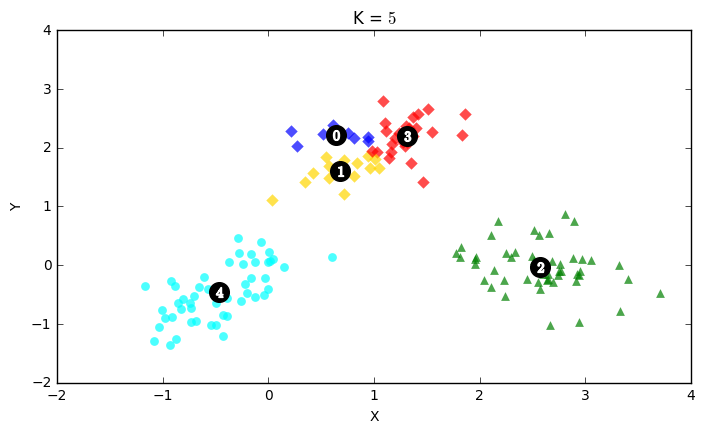

SSE = 3.84666666667
NMI = 0.873891619966
SC = 0.57748688529
CH = 370.908156942


In [15]:
# Exmple of how to give custom centers
feature_matrix, trueClusters = formatDataset(dataSets[0])
initCenters = random.sample(list(feature_matrix), 5)
runKMeansCustom(dataSets[0], initCenters)